In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import sklearn

import seaborn as sns

In [2]:
#user_table = pd.read_csv(r"C:\Users\yi6\Desktop\relax_challenge\takehome_user_engagement.csv")
#engagement_table = pd.read_csv(r"C:\Users\yi6\Desktop\relax_challenge\takehome_users.csv")

engagement = pd.read_csv(r"C:\Users\yi6\Desktop\relax_challenge\takehome_user_engagement.csv")

take_home = pd.read_csv(r"C:\Users\yi6\Desktop\relax_challenge\takehome_users.csv", encoding = "ISO-8859-1")

In [3]:
#descriptive stats
print(take_home.describe())
print(take_home.info())
print(take_home.columns)
print(take_home.head())

         object_id  last_session_creation_time  opted_in_to_mailing_list  \
count  12000.00000                8.823000e+03              12000.000000   
mean    6000.50000                1.379279e+09                  0.249500   
std     3464.24595                1.953116e+07                  0.432742   
min        1.00000                1.338452e+09                  0.000000   
25%     3000.75000                1.363195e+09                  0.000000   
50%     6000.50000                1.382888e+09                  0.000000   
75%     9000.25000                1.398443e+09                  0.000000   
max    12000.00000                1.402067e+09                  1.000000   

       enabled_for_marketing_drip        org_id  invited_by_user_id  
count                12000.000000  12000.000000         6417.000000  
mean                     0.149333    141.884583         5962.957145  
std                      0.356432    124.056723         3383.761968  
min                      0.000000  

In [6]:
#convert column to datetime and group by 9 day count
engagement['time_stamp'] = pd.to_datetime(engagement['time_stamp'])
groupby = engagement.set_index('time_stamp').groupby([pd.TimeGrouper(freq='9D'), 'user_id']).count()
groupby_2.columns = ['user_id', '9_day_count_max']

#Create target column by grouping max engagment count over 9 day interval
groupby_2["Target"] = groupby_2['9_day_count_max'].apply(lambda x: 1 if x >= 3 else 0)
groupby_2.set_index('user_id')

#rename cols and merge two data sources
take_home.rename(columns={'object_id':'user_id'}, inplace=True)
take_home_2 = pd.merge(take_home,groupby_2, how = 'left', on = 'user_id' )
take_home_2 = pd.get_dummies(take_home_2, prefix= 'creation_source', columns = ['creation_source'])
take_home_2.tail()

In [25]:
#create days since account creation col

import datetime as dt
take_home_2["creation_time"] = pd.to_datetime(take_home_2["creation_time"])
NOW=dt.datetime(2018,10,4) 
take_home_2["days_since_creation"] = take_home_2["creation_time"].apply(lambda x: (NOW - x).days)
take_home_2["days_since_creation"].head()

0    1625
1    1783
2    2024
3    1961
4    2085
Name: days_since_creation, dtype: int64

In [29]:
#grab target and predictor variables and drop nan

take_home_final =  take_home_2[['Target','days_since_creation','opted_in_to_mailing_list',
       'enabled_for_marketing_drip', 'org_id', 
       '9_day_count_max',  'creation_source_GUEST_INVITE',
       'creation_source_ORG_INVITE', 'creation_source_PERSONAL_PROJECTS',
       'creation_source_SIGNUP', 'creation_source_SIGNUP_GOOGLE_AUTH']]
take_home_final = take_home_final.dropna()
print(take_home_final.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8823 entries, 0 to 11999
Data columns (total 11 columns):
Target                                8823 non-null float64
days_since_creation                   8823 non-null int64
opted_in_to_mailing_list              8823 non-null int64
enabled_for_marketing_drip            8823 non-null int64
org_id                                8823 non-null int64
9_day_count_max                       8823 non-null float64
creation_source_GUEST_INVITE          8823 non-null uint8
creation_source_ORG_INVITE            8823 non-null uint8
creation_source_PERSONAL_PROJECTS     8823 non-null uint8
creation_source_SIGNUP                8823 non-null uint8
creation_source_SIGNUP_GOOGLE_AUTH    8823 non-null uint8
dtypes: float64(2), int64(4), uint8(5)
memory usage: 525.6 KB
None


In [41]:
#Train test split

from sklearn.model_selection import train_test_split

X = take_home_final[['days_since_creation', 'org_id','opted_in_to_mailing_list',
       'enabled_for_marketing_drip',  'creation_source_GUEST_INVITE',
       'creation_source_ORG_INVITE', 'creation_source_PERSONAL_PROJECTS',
       'creation_source_SIGNUP', 'creation_source_SIGNUP_GOOGLE_AUTH']]
y = take_home_final['Target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

Predicted   0.0  1.0   All
True                      
0.0        1349   87  1436
1.0         299   30   329
All        1648  117  1765


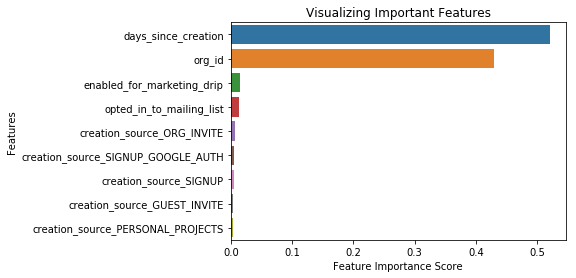

In [42]:
#instantiate RF classifier, call function, visualize feature importance and prediction matrix for imbalanced classes

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
    
from sklearn import datasets
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
    
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

clf =RandomForestClassifier()
model = clf.fit(X_train, y_train)
pred = model.predict(X_test)
a = pd.crosstab(y_test, pred, rownames=['True'], colnames=['Predicted'], margins=True)
feature_imp = pd.Series(model.feature_importances_,index=X_train.columns).sort_values(ascending=False)
print(a)
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()

In [43]:
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score

print(classification_report(y_test, pred))
print(roc_auc_score(y_test, pred))

             precision    recall  f1-score   support

        0.0       0.82      0.94      0.87      1436
        1.0       0.26      0.09      0.13       329

avg / total       0.71      0.78      0.74      1765

0.5153002260585382


# Summary

This is a really terrible classifier. Essentially, the model is categorizing every label as not a returning user. The relaively high precision/ recall of the 0 label is due to the imbalanced classes. The AUCROC score shows that the decision boundary between labels is essentially non existent, so the AUC is ~ close to random chance. I am not sure that the features included in this data set are sufficient to predict the target variable. There may be something going on with active usership and days since account creation, which could be explored further, but this alone is not sufficient to base any decisions off of. 